## Car Price Prediction - Linear Regression RFE


RFE (Recursive Feature Elimination) is a feature selection method used in data modeling. It works by recursively removing features from the input data and evaluating the model performance using the remaining features. The process continues until the desired number of features is reached or until the model performance stops improving.

### Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,scale

import statsmodels.api as sm 

C:\Users\talia\anaconda3\envs\talia_excercise\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\talia\anaconda3\envs\talia_excercise\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\talia\anaconda3\envs\talia_excercise\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Read & Checking Data

In [2]:
cars = pd.read_csv('CarPrice_Assignment.csv')
cars.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [4]:
cars.describe(include = 'object')

,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
count,205,205,205,205,205,205,205,205,205,205
unique,147,2,2,2,5,3,2,7,7,8
top,toyota corona,gas,std,four,sedan,fwd,front,ohc,four,mpfi
freq,6,185,168,115,96,120,202,148,159,94


Our data has 205 rows and 26 columns, with 0 null values. All `object` values are  categorical variable

### Feature Engineering

For the first step, I'm going to separate the car name and its brand. Then I'm going to remove the car name information and only save the brand

In [5]:
# splitting string by white space (' ') & keeping the 1st index split string (brand)
company = cars['CarName'].apply(lambda x : x.split(' ')[0])

# Create new column named CompanyName
cars.insert(2,"CompanyName",company)

# Drop the CarName column as I only use the brand information for modelling
cars.drop(['CarName', 'car_ID'],axis=1,inplace=True)

In [6]:
cars.CompanyName.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

As you may notice that some of the brands has inconsistent name (maxda - mazda, etc..). Therefore I'm going to clean this column

In [7]:
cars.CompanyName.nunique()

28

In [8]:
# Change letter into lowercase
cars.CompanyName = cars.CompanyName.str.lower()

# Create function to replace into more consistent names 
def replace_name(former, new):
    cars.CompanyName.replace(former, new, inplace = True)
    
# Change inconsistent names    
replace_name('maxda', 'mazda')
replace_name('porcshce','porsche')
replace_name('toyouta','toyota')
replace_name('vokswagen','volkswagen')
replace_name('vw','volkswagen')

# Checking number of unique names
cars.CompanyName.nunique()

22

In [9]:
cars.CompanyName.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'buick', 'mercury', 'mitsubishi',
       'nissan', 'peugeot', 'plymouth', 'porsche', 'renault', 'saab',
       'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

### EDA

In [10]:
cars.head()

,symboling,CompanyName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,audi,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,audi,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [11]:
cars.describe(include = 'object')

,CompanyName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
count,205,205,205,205,205,205,205,205,205,205
unique,22,2,2,2,5,3,2,7,7,8
top,toyota,gas,std,four,sedan,fwd,front,ohc,four,mpfi
freq,32,185,168,115,96,120,202,148,159,94


In this step, I'm going to see our target variable (`price`) distribution

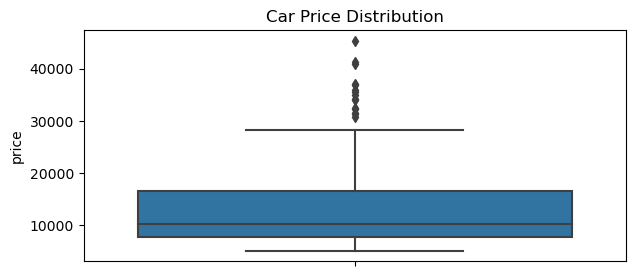

count      205.000000
mean     13276.710571
std       7988.852332
min       5118.000000
25%       7788.000000
50%      10295.000000
75%      16503.000000
max      45400.000000
Name: price, dtype: float64


In [12]:
plt.figure(figsize=(7,3))
plt.title('Car Price Distribution')
sns.boxplot(y=cars.price)
plt.show()
print(cars.price.describe())

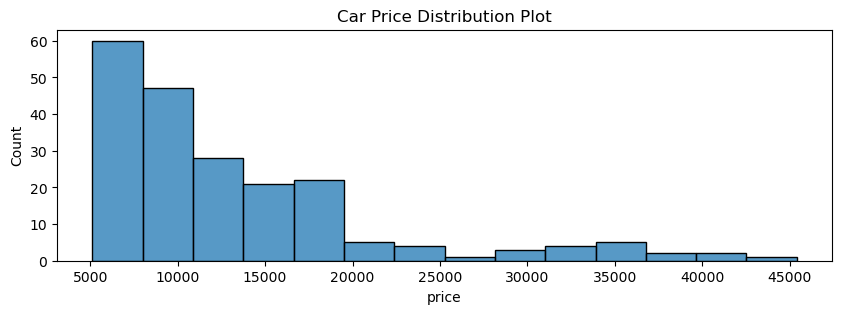

In [13]:
plt.figure(figsize=(10,3))
plt.title('Car Price Distribution Plot')
sns.histplot(cars.price)
plt.show()

As we can see above, our price data distribution has a skewed distribution with median value around 10.295, 75% of our data is arounf 16.503, and the price is considered as an outliers when the price above 30.000

### Regression Model

Since the independent variable (i.e Price) is continuous numerical variable, and there is many dependat variables, we we will use Multiple linear regression

**A. Key assumptions of multiple regression:**

To perform multiple linear regression, the following assumptions must be met:

--- Before model construction: ---

1. Linear relationship: The dependent variable Y (i.e Price) has a linear relationship with the independent variables, and to verify this, one must ensure that the XY dispersion graph is linear.
2. No multi-collinearity: Multiple regression assumes that independent variables X are not strongly correlated with each other. This assumption is tested using Variance Inflation Factor (VIF) or using Correlation Matrix .

--- After: Residual analysis of the model ---

1. Normality of Error Distribution
2. Independence of errors
3. Homo-scedasticity

### Numerical Independent Variables

#### Linear Relationship

In [14]:
import scipy
from scipy.stats import pearsonr

In [15]:
# Create function to calculate pearson correlation between X & Y variables
def calculate_pearson_coef(column):
    pearson_coeff, p_value = pearsonr(cars[column],cars['price'])
    return column, pearson_coeff*100

In [16]:
# Choose only numeric variables
numeric_features = cars.select_dtypes(include = 'number').columns

#exclude symboling and price column (Price as Y variable itself, and symboling is a categorical values)
numeric_features = numeric_features.drop(['symboling', 'price'])

In [17]:
[calculate_pearson_coef(column) for column in numeric_features]

[('wheelbase', 57.78155982921503),
 ('carlength', 68.2920015677962),
 ('carwidth', 75.93252997415115),
 ('carheight', 11.933622657049447),
 ('curbweight', 83.53048793372967),
 ('enginesize', 87.41448025245117),
 ('boreratio', 55.317323679844364),
 ('stroke', 7.9443083881931),
 ('compressionratio', 6.798350579944261),
 ('horsepower', 80.81388225362215),
 ('peakrpm', -8.526715027785686),
 ('citympg', -68.575133602704),
 ('highwaympg', -69.75990916465562)]

**Conclusion**

(+) positively correlated variables with Price: wheelbase, carlenght, carwidth, curbweight, enginesize, boreratio, horesepower

(-) negatively correlated variables with Price: citympg, highwaympg

These variables should be kept for a better model, and the other variables should be ignored as they are not correlated with Price

#### Multicolinearity

In [18]:
def heatmap(x,y,dataframe):
    sns.heatmap(dataframe.corr(),cmap="YlGnBu",annot=True)
    plt.show()

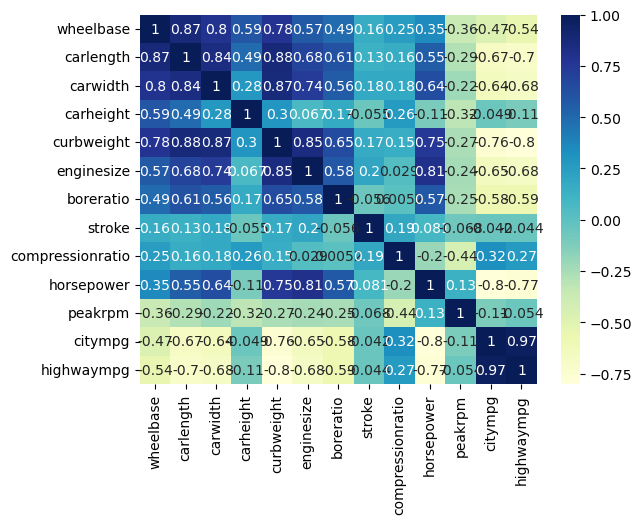

In [119]:
heatmap(20,20,cars.loc[:,numeric_features])

**Wheelbase , carlength, carwidth and curbweight** [ 0.80 - 0.88 ] are very correlated and we have to keep only one between them. 

**Horsepower and enginesize** are highly correlated and we need to keep only one. 

**citympg and highwaympg** are highly correlated and we need to keep one of them.

#### Categorical Variables

Dummy variables are used to convert a categorical variable with two or more levels into a numerical variable that can be used in regression analysis.

In [20]:
cars.select_dtypes(include = 'object').describe()

,CompanyName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
count,205,205,205,205,205,205,205,205,205,205
unique,22,2,2,2,5,3,2,7,7,8
top,toyota,gas,std,four,sedan,fwd,front,ohc,four,mpfi
freq,32,185,168,115,96,120,202,148,159,94


#### Dummy Variable for categoric columns

Notice that some of the variables have only 2 unique values, therefore we're going to convert them into:

**fueltype {" gas ": 1, " diesel ": 0}**

**suction {" std ": 1, " turbo ": 0}**

**doornumber {" two ": 1, " oven ": 0}**

**enginelocation {" front ": 1, " rear ": 0}**

In [21]:
#Create dummy variable function
def dummies(x,df):  
    
    # Set initial column names as prefix to new column
    temp = pd.get_dummies(df[x], prefix=x, drop_first = True)
    
    # performing dummy variable concatenation to data frame
    df = pd.concat([df, temp], axis = 1)
    
    # Drop initial column
    df.drop([x], axis = 1, inplace = True)
    return df

In [22]:
cars_df = cars.copy()

cars_df = dummies('symboling',cars_df)
cars_df = dummies('CompanyName',cars_df)
cars_df = dummies('fueltype',cars_df)
cars_df = dummies('aspiration',cars_df)
cars_df = dummies('doornumber',cars_df)
cars_df = dummies('carbody',cars_df)
cars_df = dummies('drivewheel',cars_df)
cars_df = dummies('enginelocation',cars_df)
cars_df = dummies('enginetype',cars_df)
cars_df = dummies('cylindernumber',cars_df)
cars_df = dummies('fuelsystem',cars_df)

In [23]:
# dummy variables
cars_df.iloc[:5,16:28]

,symboling_1,symboling_2,symboling_3,CompanyName_audi,CompanyName_bmw,CompanyName_buick,CompanyName_chevrolet,CompanyName_dodge,CompanyName_honda,CompanyName_isuzu,CompanyName_jaguar,CompanyName_mazda
0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,0,0,0,0,0


### Model Building

### Splitting Data & Feature Scaling

In [24]:
np.random.seed(100)
cars_train, cars_test= train_test_split(cars_df, train_size=0.7, test_size=0.3, random_state = 100)

In [25]:
# Column index which needs to be scaled
cars_df.iloc[:3,:14]

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0


In [26]:
# Scaling values to evade multicolinearity
sc = StandardScaler() 

col_to_scale = cars_df.iloc[:,:14].columns

cars_train[col_to_scale] = sc.fit_transform(cars_train[col_to_scale])
cars_test[col_to_scale] = sc.fit_transform(cars_test[col_to_scale])

cars_train.head()

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,...,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
122,-0.811836,-0.487238,-0.924500,-1.134628,-0.642128,-0.660242,-1.297329,-0.064443,-0.172569,-0.872898,...,0,0,0,1,0,0,0,0,0,0
125,-0.677177,-0.359789,1.114978,-1.382026,0.439415,0.637806,2.432256,-0.449757,-0.146125,1.021826,...,0,0,0,0,0,0,0,1,0,0
166,-0.677177,-0.375720,-0.833856,-0.392434,-0.441296,-0.660242,-0.259197,-0.546085,-0.172569,0.238673,...,0,0,0,0,0,0,0,1,0,0
1,-1.670284,-0.367754,-0.788535,-1.959288,0.015642,0.123485,0.625138,-1.830463,-0.278345,0.213410,...,0,0,0,0,0,0,0,1,0,0
199,0.972390,1.225364,0.616439,1.627983,1.137720,0.123485,1.201877,-0.321319,-0.675002,1.501822,...,0,0,0,0,0,0,0,1,0,0


In [27]:
y_train = cars_train.loc[:,cars_train.columns == 'price']

X_train = cars_train.loc[:, cars_train.columns != 'price']

In [28]:
y_test = cars_test.loc[:,cars_test.columns == 'price']

X_test = cars_test.loc[:, cars_test.columns != 'price']

### Regression Model

### RFE

RFE (Recursive Feature Elimination) is a feature selection method used in data modeling. It works by recursively removing features from the input data and evaluating the model performance using the remaining features. The process continues until the desired number of features is reached or until the model performance stops improving

In [29]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [30]:
# Create initial linear model
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [62]:
# Perform RFE with linear model and select 13 features model base model
rfe = RFE(estimator = lm, n_features_to_select =13)
rfe = rfe.fit(X_train,y_train)

In [57]:
# Check for rfe.support_ and ranking
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('wheelbase', False, 27),
 ('carlength', False, 28),
 ('carwidth', False, 21),
 ('carheight', False, 26),
 ('curbweight', False, 9),
 ('enginesize', True, 1),
 ('boreratio', False, 17),
 ('stroke', False, 38),
 ('compressionratio', False, 34),
 ('horsepower', False, 40),
 ('peakrpm', False, 36),
 ('citympg', False, 52),
 ('highwaympg', False, 45),
 ('symboling_-1', True, 1),
 ('symboling_0', True, 1),
 ('symboling_1', True, 1),
 ('symboling_2', True, 1),
 ('symboling_3', True, 1),
 ('CompanyName_audi', True, 1),
 ('CompanyName_bmw', True, 1),
 ('CompanyName_buick', True, 1),
 ('CompanyName_chevrolet', False, 29),
 ('CompanyName_dodge', False, 25),
 ('CompanyName_honda', False, 23),
 ('CompanyName_isuzu', False, 51),
 ('CompanyName_jaguar', False, 31),
 ('CompanyName_mazda', False, 47),
 ('CompanyName_mercury', False, 54),
 ('CompanyName_mitsubishi', False, 18),
 ('CompanyName_nissan', False, 44),
 ('CompanyName_peugeot', False, 10),
 ('CompanyName_plymouth', False, 24),
 ('CompanyName

we got the information of each features, boolean values, and rangking information (integer). The boolean values indicating whether the variabel is significant to our model (False values for discarded veatures)

In [58]:
X_train.columns[rfe.support_]

Index(['enginesize', 'symboling_-1', 'symboling_0', 'symboling_1',
       'symboling_2', 'symboling_3', 'CompanyName_audi', 'CompanyName_bmw',
       'CompanyName_buick', 'CompanyName_porsche', 'CompanyName_saab',
       'CompanyName_volvo', 'cylindernumber_two'],
      dtype='object')

#### Buil Model according to RFE result

In [59]:
# Subset X_train column to create base model
X_train_rfe_base = X_train[X_train.columns[rfe.support_]]
X_train_rfe_base.head()

,enginesize,symboling_-1,symboling_0,symboling_1,symboling_2,symboling_3,CompanyName_audi,CompanyName_bmw,CompanyName_buick,CompanyName_porsche,CompanyName_saab,CompanyName_volvo,cylindernumber_two
122,-0.660242,0,0,1,0,0,0,0,0,0,0,0,0
125,0.637806,0,0,0,0,1,0,0,0,1,0,0,0
166,-0.660242,0,0,1,0,0,0,0,0,0,0,0,0
1,0.123485,0,0,0,0,1,0,0,0,0,0,0,0
199,0.123485,1,0,0,0,0,0,0,0,0,0,1,0


We need to create base (inital) model to compare model performace with another model and get the best model

In [60]:
def build_model(X,y):
    X = sm.add_constant(X) #Adding constant as independent variable to help estimate coefficient
    lm = sm.OLS(y,X).fit() # fitting the model
    print(lm.summary())
    return X
   
def check_VIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

#### Model 1 : 13 Features

In [61]:
X_train_1 = build_model(X_train_rfe_base,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     105.1
Date:                Tue, 18 Apr 2023   Prob (F-statistic):           5.62e-62
Time:                        11:18:46   Log-Likelihood:                -27.684
No. Observations:                 143   AIC:                             83.37
Df Residuals:                     129   BIC:                             124.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.0681    

All features p-values are below 0.05

In [63]:
check_VIF(X_train_1)

,Features,VIF
0,const,132.14
3,symboling_0,30.74
4,symboling_1,28.63
6,symboling_3,15.50
5,symboling_2,14.90
2,symboling_-1,8.87
12,CompanyName_volvo,2.44
9,CompanyName_buick,1.70
1,enginesize,1.68
13,cylindernumber_two,1.42


I'm going to drop all symboling column because of high VIF

#### Model 2 : 9 Features

In [65]:
X_train_2 = X_train_1.drop(['symboling_0', 'symboling_1', 'symboling_3', 'symboling_2'], axis = 1)

In [67]:
X_train_2 = build_model(X_train_2,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     138.8
Date:                Tue, 18 Apr 2023   Prob (F-statistic):           4.07e-63
Time:                        11:31:50   Log-Likelihood:                -35.542
No. Observations:                 143   AIC:                             91.08
Df Residuals:                     133   BIC:                             120.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.2160    

symboling_-1 p-value > 0.05, therefore I'm going to drop this feature

In [68]:
check_VIF(X_train_2)

,Features,VIF
2,symboling_-1,1.72
5,CompanyName_buick,1.58
1,enginesize,1.44
0,const,1.38
8,CompanyName_volvo,1.34
4,CompanyName_bmw,1.11
6,CompanyName_porsche,1.08
9,cylindernumber_two,1.06
3,CompanyName_audi,1.02
7,CompanyName_saab,1.01


#### Model 3: 8 Features

In [74]:
X_train_3 = X_train_2.drop(['symboling_-1'], axis = 1)

In [75]:
X_train_3 = build_model(X_train_3,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     156.6
Date:                Tue, 18 Apr 2023   Prob (F-statistic):           4.02e-64
Time:                        11:39:39   Log-Likelihood:                -35.806
No. Observations:                 143   AIC:                             89.61
Df Residuals:                     134   BIC:                             116.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.2118    

In [76]:
check_VIF(X_train_3)

,Features,VIF
1,enginesize,1.43
0,const,1.33
4,CompanyName_buick,1.22
3,CompanyName_bmw,1.10
5,CompanyName_porsche,1.08
8,cylindernumber_two,1.06
7,CompanyName_volvo,1.04
2,CompanyName_audi,1.02
6,CompanyName_saab,1.01


### Redisual Assumption

In [77]:
lm_final = sm.OLS(y_train,X_train_3).fit()
y_train_price = lm_final.predict(X_train_3)

# Calculate residuals from train prediction
resid = y_train.price - y_train_price

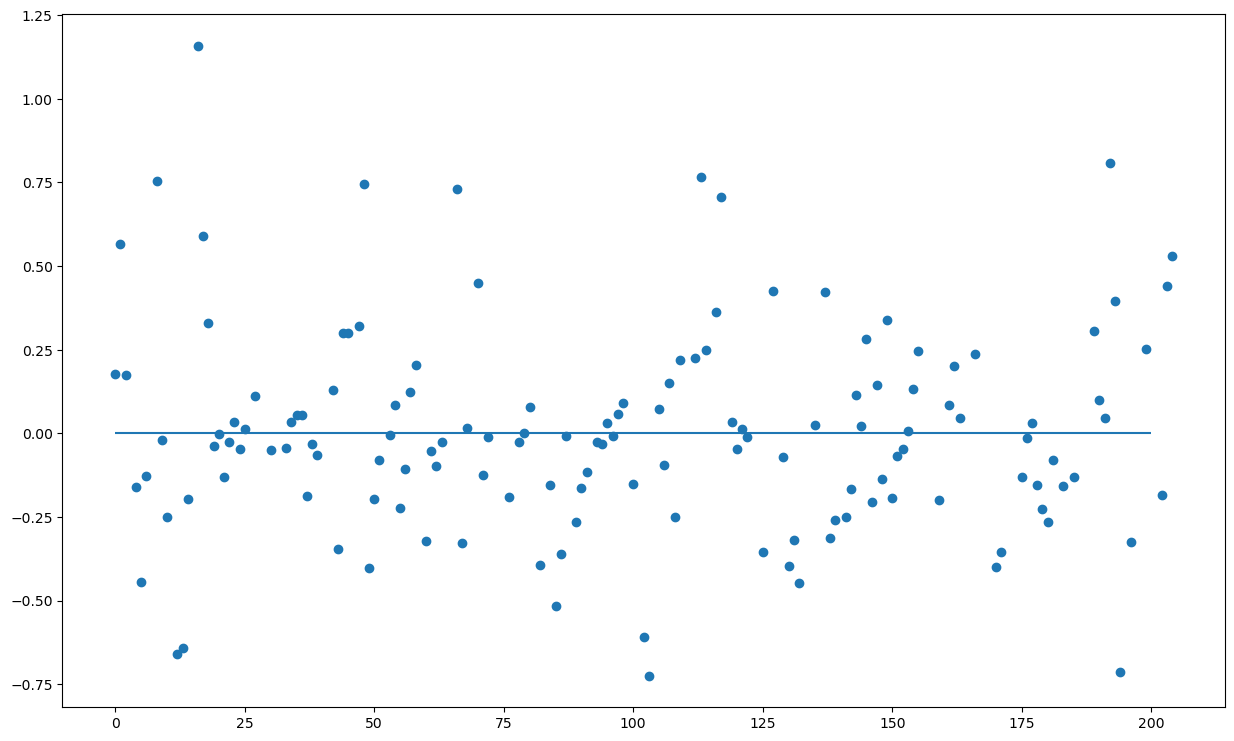

In [105]:
plt.figure(figsize=(15,9))
plt.scatter(resid.index, resid.values)
plt.hlines(0,0,200)

**Durbin-Watson tests**

The test of Durbin-Watson tests the null hypothesis that the residuals are not dependent (autocorrelated) on each other.
The Durbin-Watson statisticlies in the range 0-4. A value of 2 or nearly 2 indicates that there is no first-order autocorrelation. An acceptable range is 1.50 - 2.50.

Where successive error differences are small, Durbin-Watson is low (less than 1.50); this indicates the presence of positive autocorrelation. Positive autocorrelation is very common. Where successive error differences are large, Durbin-Watson is high (more than 2.50); this indicates the presence of negative autocorrelation. Negative autocorrelation is not particularly common.

In time series with lagged variables, the Durbin-Watson statistic is unreliable as it tends toward a value of 2.0.

In general, values of d ~ 2 indicate that there is no dependence (no autocorrelation) between the residuals.

In [110]:
from statsmodels.stats.stattools import durbin_watson
print(durbin_watson(resid))

1.9614736681524152


Durbin-Watson test result is very close to 2, indicating no autocorellation

#### Homoscedasticity

In [116]:
sms.het_goldfeldquandt(resid, lm_final.model.exog)

(0.8167739833815822, 0.7879598423483373, 'increasing')

Analysis:

P-Value test Goldfeld-Quandt (0.7) > 0.05, so we accept H0 saying that the error terms are homoscedastic, which means that the residuals have a constant variance

### Prediction and Evaluation

#### Data test preparation

*Note: I have scaled the data test values in the previous step, so that I only need to adjust data test features based on the model final variables*

In [124]:
cars_test.head(3)

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,...,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
160,-0.587157,-0.794680,-0.845273,-0.464750,-1.086333,-0.780488,-0.669882,-0.753102,-0.310803,-0.969994,...,0,0,0,1,0,0,0,0,0,0
186,-0.325847,-0.328646,-0.286672,0.651450,-0.691974,-0.523466,-0.669882,0.418958,-0.310803,-0.584319,...,0,0,0,0,0,0,0,1,0,0
59,-0.080869,0.197800,0.221147,-0.175365,-0.452308,-0.219712,0.030501,0.387280,-0.402893,-0.610031,...,0,0,0,1,0,0,0,0,0,0


In [125]:
final_features = list(X_train_3.columns)

X_test_new = X_test.filter(final_features)

# # Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [130]:
X_test_new.head(1)

,const,enginesize,CompanyName_audi,CompanyName_bmw,CompanyName_buick,CompanyName_porsche,CompanyName_saab,CompanyName_volvo,cylindernumber_two
160,1.0,-0.780488,0,0,0,0,0,0,0


In [132]:
# Predictions
y_pred = lm_final.predict(X_test_new)

In [133]:
from sklearn.metrics import r2_score 
r2_score(y_test, y_pred)

0.9034072637825475

### RMSE Calculation

In [135]:
from sklearn.metrics import mean_squared_error as MSE
import math

mse = MSE(y_test, y_pred)
math.sqrt(mse)

0.31079371972009406